<h1 align="center">Predicting the UEFA European Football Championship</h1>

<h1 style="font-size:12px" align="center">Tutorial by Aabid Roshan, Sid Joshi, Pranav Sivaraman</h1>

---

<h1 align="center">
    Introduction
</h1>

<h1 style="font-size:18px">
    Tournament info
</h1>

<p style="font-size:16px">
    The UEFA European Football Championship, also known as the Euros, is a tournament held by UEFA every four years which consists of countries in Europe. There are also similar competitions for other continents such as the CONCACAF Gold Cup which is held for North American international teams. Although there are many different continental competitions, the Euros are by far the most popular because the majority of the worlds best players play for European teams. Although this competition is called the 2020 Euros, it is being held in 2021 because of COVID. Currently the qualifiers for the tournment have already been played and the 24 teams that go into the tournament have already been decided. Later on you will see a list of these teams. The current reigning champions are Portugal.
</p>

<p style="font-size:16px">
    The format of the tournament starts off with a group stage where there are 6 groups of 4 teams each. During the group stage each team will play every other team twice, once at home and once away from home. Each team gets 3 points for a win, 1 for a draw, and 0 for a loss. At the end of the group stage, the top 2 teams move on to the next round and play in a standard knockout style tournament.
</p>

<h1 style="font-size:18px">
    Why do we want to predict the winner?
</h1>

<p style="font-size:16px">
    This is a pretty easy question to answer. Like with many other popular tournaments there are many uses for predicting the winner from something a trivial as bragging rights all the way to deciding which team to bet on to win the whole thing.
</p>

<h1 align="center">
    Data Scraping
</h1>
<p style="font-size:16px">
    First off, here are the libraries we used throughout the tutorial.
</p>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 7600 ~/.kaggle/kaggle.json
!kaggle datasets download -d martj42/international-football-results-from-1872-to-2017

mkdir: cannot create directory ‘/home/psivaram/.kaggle’: File exists
international-football-results-from-1872-to-2017.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip international-football-results-from-1872-to-2017.zip

Archive:  international-football-results-from-1872-to-2017.zip
replace results.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

plt.style.use('seaborn')

<h1 style="font-size:20px">
    Loading the Data
</h1>
<p style="font-size:16px">
    Fortunately for us, all international game data was stored in a csv file and can be downloaded from <a href="https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017">this website</a>. The data was created by Mart Jürisoo so extra thanks to him.   
</p>
<p style="font-size:16px">
    To extract the data from the file we use the pandas
        <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html">read_csv</a> function and put the data into a dataframe. After extracting the data we want to convert the data column into a datetime object so it can be used to make things more convenient later on. This can be done by using the pandas <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">to_datetime</a> function.
</p>

In [28]:
df = pd.read_csv("results.csv")
df['date'] = pd.to_datetime(df['date'])
df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


<p style="font-size:16px">
    This is the data we will be using going forward. Below is a list of what each column represents.
    <ol>
        <li><b>date:</b> The date of the match</li>
        <li><b>home_team:</b> The home team</li>
        <li><b>away_team:</b> The away team</li>
        <li><b>home_score:</b> The number of goals scored by the home team</li>
        <li><b>away_score:</b> The number of goals scored by the away team</li>
        <li><b>tournament:</b> This is the name of the competition the match was played in. This could range anywhere from a simple friendly to a Worl Cup Final game. There are many different competitions around the world</li>
        <li><b>city:</b> The city the game was played in</li>
        <li><b>country:</b> The country the game was played in</li>
        <li><b>neutral:</b> This is whether or not the game was played at a neutral stadium. A neutral stadium is when neither team is home nor away. Both teams must travel to a stadium that is not their own</li>
    </ol>
</p>

---

<h1 align="center">
    Exploratory Data Analysis
</h1>

<h1 style="font-size:18px">
    Creating the Ranking System
</h1>

<p style="font-size:16px">
    These are a list of the teams we are going to look at. The current list of teams below was chosen based on the qualifiers for the upcoming 2020 UEFA European Football Championship. These are the teams that qualified for said tournament. The teams can be changed if need be.
</p>

In [29]:
teams = ['Turkey', 'Italy', 'Wales', 'Switzerland',
         'Denmark', 'Finland', 'Belgium', 'Russia',
         'Netherlands', 'Ukraine', 'Austria', 'North Macedonia',
         'England', 'Croatia', 'Scotland', 'Czech Republic',
         'Spain', 'Sweden', 'Poland', 'Slovakia',
         'Hungary', 'Portugal', 'France', 'Germany']

<p style="font-size:16px">
    The methods below are used to calculate the elo of respective teams as used by FIFA. 
For more information on the math behind the calculations look at <a href="https://en.wikipedia.org/wiki/World_Football_Elo_Ratings">this link</a>
</p>

In [30]:
def initialize_elo_system(teams, initial_rating, start_year):
    ratings = {}
    for team in teams:
        start_date = np.datetime64(f'{start_year}-01', 'D')
        ratings[team] = [initial_rating], [start_date]
        
    return ratings

In [31]:
def calculate_probabilities(home_rating, away_rating, scale_factor=400):
    p_home = 1 / (1 + 10**((away_rating - home_rating) / scale_factor))
    p_away = 1 / (1 + 10**((home_rating - away_rating) / scale_factor)) 
    
    return p_home, p_away

In [32]:
def calculate_ratings(matches, ratings, k_factor=22.2):
    num_matches = len(matches)
    home_teams, away_teams = matches['home_team'].values, matches['away_team'].values
    home_scores, away_scores = matches['home_score'].values, matches['away_score'].values
    match_dates = matches['date'].values
    
    for i in range(num_matches):
        home_team, away_team = home_teams[i], away_teams[i]
        home_score, away_score = home_scores[i], away_scores[i]
        match_date = match_dates[i]
                
        p_home, p_away = calculate_probabilities(ratings[home_team][0][-1], ratings[away_team][0][-1])
        
        if home_score > away_score:
            match_result_home = 1
            match_result_away = 0
        elif home_score < away_score:
            match_result_home = 0
            match_result_away = 1
        elif home_score == away_score:
            match_result_home = 0.5
            match_result_away = 0.5
            
        new_rating_home = ratings[home_team][0][-1] + k_factor * (match_result_home - p_home)
        new_rating_away = ratings[away_team][0][-1] + k_factor * (match_result_away - p_away)
        
        ratings[home_team][0].append(new_rating_home)
        ratings[away_team][0].append(new_rating_away)
        
        ratings[home_team][1].append(match_date)
        ratings[away_team][1].append(match_date)
        
    return ratings

In [33]:
def convert_to_df(ratings, start_year):
    today = date.today()
    date_range = pd.date_range(start=f'1/1/{start_year}', end=today.strftime("%m/%d/%Y"))
    
    for country in ratings:
        df = pd.DataFrame(ratings[country][0], ratings[country][1], columns=[country])
        df = df.reindex(date_range, method='pad')
        ratings[country] = df
        
    ratings = pd.concat(list(ratings.values()), axis=1)
    
    return ratings

In [34]:
def calculate_elo(teams, year_range, initial_rating=1200):
    ratings = initialize_elo_system(teams, initial_rating, year_range[0])
    matches = df[df['home_team'].isin(teams) & df['away_team'].isin(teams)]
    matches = matches[matches['date'].dt.year.between(year_range[0], year_range[1])]
    new_ratings = calculate_ratings(matches, ratings)
    new_ratings = convert_to_df(new_ratings, year_range[0])
    
    return new_ratings

In [57]:
def plot_elos(ratings):
    plt.figure(figsize=(15, 10))
    
    for country in teams:
        dates, elos = ratings.index.values, ratings[country].values
        plt.plot(dates, elos, label=country)
        legend = plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')

In [58]:
ratings = calculate_elo(teams, [2016, 2021])
rankings = ratings.iloc[-1,:].sort_values(ascending=False)

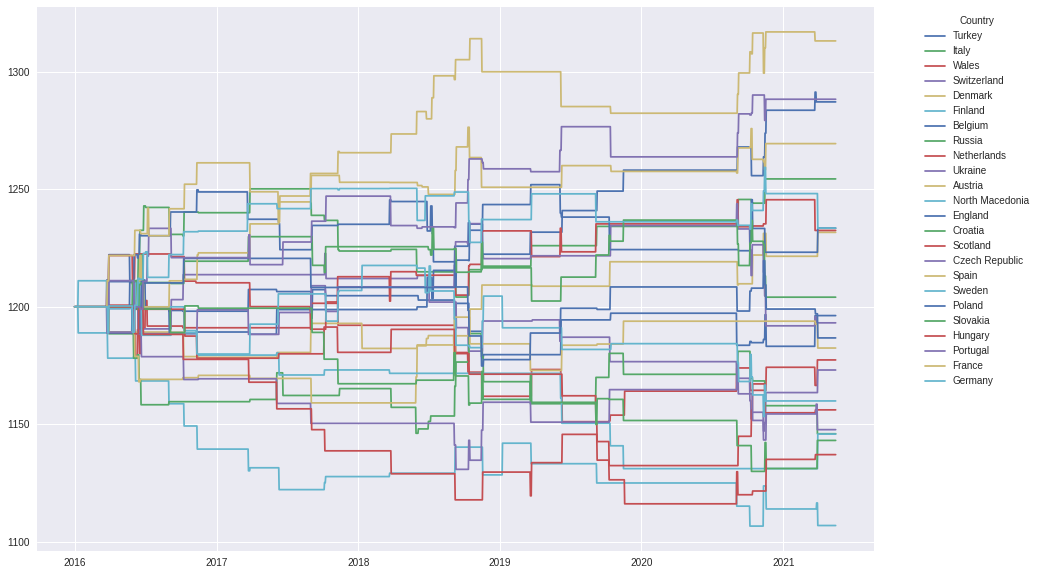

In [61]:
plot_elos(ratings)

---
# Seeing if being at home gives teams an advantage

In [ ]:
def calculate_home_percentages(year_range=None):
    
    # This method calculates winning/non-losing percentages for home teams
    #
    #
    # Inputs:
    #     year_range: An array containing two elements [start, end]
    #                 No input will calculate from all years
    #
    # Outputs: 
    #     W: win rate of the home team
    #     U: non-losing percentages of the home team (Undefeated percentages)
    
    home_win = 0
    draw = 0
    total = 0
    
    nonneutral = df[df['neutral'] == False]
    if year_range != None:
        nonneutral = nonneutral[nonneutral['date'].dt.year.between(year_range[0], year_range[1])]

    for index, row in nonneutral.iterrows():
        if row['home_score'] > row['away_score']:
            home_win += 1
        elif row['home_score'] == row['away_score']:
            draw += 1
        total += 1

    return (home_win/total*100, (home_win+draw)/total*100)

In [ ]:
calculate_home_percentages()

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

# The Search For Fantasy Gold

Some believe that there is no sports without fantasy. This community is just as crazy and prevalent in the world of football. Whether it's Premier League Fantasy, UEFA Champions League Fantasy, or World Cup Fantasy, football fantasy fans are all in. That's why this data science guide to the Euros would not be complete if we didn't dedicate a section just for fantasy. Before the fantasy fans get too eager, let's get started...

So first things first, if you are new to the realm of fantasy football don't worry. Here's the basics of how fantasy works... in most fantasy football formats (yes there are multiple fantasy games for the same sporting event, as you could imagine one simply wouldn't be enough for the fantasy community) you are given a certain amount of budget at the start of the season to build your squad. Using that budget, you pick a set of 15 or so players (a starting 11 plus bench players) from the entire selection of players available. Each player in the game is given a particular price tag, with the "better"/more high profile players costing more than other players. Once you have picked your initial team, you pick a starting 11 for each matchweek/gameweek, during which the players in your 11 rack up points based on how will they perform (in real life) during that week. Points are usually awarded for every goal scored, every assist, clean sheets, minutes played, saves (for goalkeepers), etc. Come the end of the season, the more total points you accumulate the higher up you are in the leaderboard (whether that's worldwide, or simply a mini league you and your colleagues at work/school started). Note that there are more involved aspects of fantasy such as weekly transfers, captaincy, chips like wildcard and benchboost, etc. but we are not going to dive into these aspects as they are not necessary to get you started (and in fact, have no effect on the area of focus for this guide, which will be the initial team selection).

Okay, so now that you know the basics of fantasy, let's talk about how it relates to the Euros! As you might imagine, just as there are fantasy games for the annual football leagues played across the world (like the English Premier League, the German Bundesliga, the Italian Serie A, etc.), there are also fantasy games for singular tournaments such as the World Cup and the Euros (which take place every four years). Since the tournament duration is only a month or two, the fantasy game will only run for the duration of the tournament. In fantasy games involving international tournaments, the game is usually split into two phases. One phase for the group stages and one phase for the knockout rounds. In other words, you get to choose an initial team to play during the group stage portion of the tournament (where each team is guaranteed to play 3 games against the other teams in their group), and then get to select a completely new squad for the knockout rounds, choosing players from the teams that are still alive in the tournament. 

In this guide, we will solely focus on selecting the "best" players for the group stages. This is due to the fact that the group stages are the first phase of the Euro Fantasy game, and more importantly, since all we know are the teams who have qualified for the tournament, we can't make selections for the knockout stages as there is always the possibility that the players we pick are on teams that do not advance to the knockout stages (and hence will earn no points). Additionally, we will not be focusing on finding budget value players (players that are underpriced in the game when compared to their points potential) and will instead be focusing on picking the "best" fantasy assets on the pure basis of their form and potential for scoring loads of points (regardless of how expensive they are). In other words, this guide will be our selection of who we think are going to be the players who score the most points overall, and therefore serving as the foundational set of players you can build your team around (you think of it as the core players who will make up the largest chunk of your budget, but consequently expected to produce the most fantasy returns). Our aim is that by the end of this section, you will not just have a set of fantasy players who will help you kill it in fantasy this Euros (whether it's your first time playing or hundredth) but also understand the process of data representation, exploration, and analysis used to produce these picks. That way, you won't just do well this year, but have the necessary skillset to conduct your own data science to find the best players for your fantasy team next time out (as we hope you'll keep playing!). 

Without further to do, let's dive deep into the search for fantasy gold...

So first things first. We are going to split our analysis into two parts. The first part will be dedicated towards attackers, which encompasses forwards and midfielders. The second part will focus on defenders (which includes goalkeepers as well).

## Part 1: Attackers

Whether you or a soccer fan or not, we all know one thing: attackers score goals. As you might imagine, this mantra is very relevant when thinking about what attackers to select for your fantasy team. No matter what version of a fantasy game you play, the idea that "the more goals your attackers score the better of your fantasy team will be" holds true. After all, goals are the bread and butter of attackers. So with this in mind, let's zoom our lens in on the topscorers of each team. More specifically, the topscorers for each team during Euro Qualifiers (you guessed it. it's the set of games teams had to play in order to qualify for the tournament). Our hypothesis is that the topscorers for each team during the qualifiers are more likely to score during the group stages of the actual tournament. Let's see if this is the case by taking a look at the Euro's of previous years, and see what percentage of top scorers actually ended up scoring at least 1 goal in the group stages of the actual tournament.

Let's start by focusing on Euro 2012, in particular, and see what results we get. We can't do any data science without getting the data first, so let's scrape the internet for information on how each team did during qualifying, as well as the topscorers for each team in the matches played, and collect that into pandas dataframes.

In [ ]:
# Getting the html of the website we will be scraping from (it's gotta be Wikipedia, of couse)
website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_2012_qualifying#Groups')

In [ ]:
website.content

In [ ]:
# Let's clean the html up a bit with BeautifulSoup
website_formatted = BeautifulSoup(website.content)
website_formatted

In [ ]:
# Creating data frame which we will populate with data for each team, specifically how they fared in their qualifying
# group, info such as games played, wins, draws, losses, goals scored, goals conceded, goal difference, and points tally
euro_2012_qualifying_teams_df = pd.DataFrame(columns = ['Team','Pld','W','D','L','GF','GA','GD','Pts'])
euro_2012_qualifying_teams_df

In [ ]:
# Here's the list of teams who played in Euro 2012 (this is excluding Poland and Ukraine since, they were the
# teams to host the Euros and therefore gained automatic qualification and didn't have to play in qualifiers)
teams = ['Czech Republic','Greece','Russia',
         'Germany','Portugal','Denmark','Netherlands',
         'Spain','Italy','Croatia','Republic of Ireland',
         'England','France','Sweden']

# For each team we will scrape the Wikipedia page for the row containing the team information we need.
for team in teams:
    # Data we need is within a <th> tag so finding all <th> tags.
    all_table_headers = website_formatted.findAll('th')
    table_headers_w_span_tag = []
    # Getting all span tags found within our list of <th> tags
    for th in all_table_headers:
        curr_th_all_span_tags = th.findAll('span')
        for curr_span_tag in curr_th_all_span_tags:
            table_headers_w_span_tag.append(curr_span_tag)

    # List we will populate with all the <a> tags which are found within our list of span tags
    a_tags = []
    for span in  table_headers_w_span_tag:
        curr_span_a_tags = span.findAll('a', {'title' : team+' national football team'}, text=team)
        for curr_span_a_tag in curr_span_a_tags:
            a_tags.append(curr_span_a_tag)
    
    # Target tag will be assigned to the <a> tag which marks the point in the html from which the information we need lies
    target_tag = None
    for a_tag in a_tags:
        tag_style = a_tag.find_next('td').attrs.get('style')
        # We are looking for the <a> tag which has a style attribute
        if tag_style != None:
            target_tag = a_tag
            break # The moment we find our target tag we will terminate the for-loop.
        
    curr_tag = target_tag.find_next('td')

    team_data = [] # list we will populate with elements containing information pertaining to the team currently being processed.
    team_data.append(team) # adding team name info to our list

    # Iterating through the siblings of the <a> tag we identified as our target tag, and grabbing the data we need from each of the siblings
    for i in range(1,9):
        data = curr_tag.text.strip('\n')
        team_data.append(data)
        curr_tag = curr_tag.find_next('td')

    # Appending team data that was just parsed and obtained in the form of a list as a row in our dataframe.
    euro_2012_qualifying_teams_df = euro_2012_qualifying_teams_df.append(pd.DataFrame([team_data], columns=euro_2012_qualifying_teams_df.columns))

euro_2012_qualifying_teams_df = euro_2012_qualifying_teams_df.reset_index(drop=True)
euro_2012_qualifying_teams_df

Okay looks like we got the team information! A quick cross-check with the actual data on Wikipedia confirms that the scrape and move into a panda dataframe was successful. That being said, there are a few minor adjustments we must make. Specifically, the teams Croatia, the Republic of Ireland, Czech Republic, and Portugal all played in the qualifier play-offs, which were additional games that had to be played in order for them to get into the tournament. The data we scraped was only the teams' results from the qualifying group stages, so we must add the data from the play-offs for the aforementioned 4 teams. Here were the playoff games...

Croatia
<br>
Game 1: 3-0 win
<br>
Game 2: 0-0 draw
<br>

Republic of Ireland
<br>
Game 1: 4-0 win
<br>
Game 2: 1-1 draw
<br>

Czech Republic
<br>
Game 1: 2-0 win
<br>
Game 2: 1-0 win
<br>

Portugal
<br>
Game 1: 0-0 draw
<br>
Game 2: 6-2 win
<br>

Based on these results, let's adjust the values in our table for the respective teams involved.

In [ ]:
# Indices of teams in play-offs
playoff_teams = [0,4,9,10]

# Since each play-off team played an additional 2 games, adding those to the respective games played counts for each play-off team
for index in playoff_teams:
    euro_2012_qualifying_teams_df.at[index,'Pld'] = int(euro_2012_qualifying_teams_df.at[index,'Pld']) + 2
    
# Adjustments for Czech Republic
euro_2012_qualifying_teams_df.at[0,'GF'] = '15'
euro_2012_qualifying_teams_df.at[0,'GD'] = '+7'
# Adjustments for Portugal
euro_2012_qualifying_teams_df.at[4,'GF'] = '27'
euro_2012_qualifying_teams_df.at[4,'GA'] = '14'
euro_2012_qualifying_teams_df.at[4,'GD'] = '+13'
# Adjustments for Croatia
euro_2012_qualifying_teams_df.at[9,'GF'] = '21'
euro_2012_qualifying_teams_df.at[9,'GD'] = '+14'
# Adjustments for Ireland
euro_2012_qualifying_teams_df.at[10,'GF'] = '20'
euro_2012_qualifying_teams_df.at[10,'GA'] = '8'
euro_2012_qualifying_teams_df.at[10,'GD'] = '+12'

euro_2012_qualifying_teams_df

Okay, now that we have made the adjustments necessary for the teams table, we can move on to scraping the top goalscorer data... in order to get the top goalscorer data for each team, let's first scrape the webpage to get all the goalscorers who played for teams that successfully qualified for the Euros. Then we can filter this dataframe as
needed, to get the top goalscorers for each team.

In [ ]:
# Creating data frame which we will populate with data pertaining to all the goalscorers during the Euro 2012 qualifiers,
# data will include player name, team, and number of goals scored.
euro_2012_qualifying_goalscorers_df = pd.DataFrame(columns = ['Player','Team','Goals_Scored'])

In [ ]:
import re # Will be using regex

# This anchor, marks the starting point in the html we will parse from, as this is where the Wikipedia page
# begins displaying information regarding the top goalscorers during qualifiers.
anchor = website_formatted.find(text="There were 665 goals scored in 248 matches, for an average of 2.68 goals per match.")
curr_goal_section = anchor.find_next('p')

# Iterating over each category of goals (12 goals, 9 goals, 7 goals, 6 goals, 5 goals, etc.)
for i in range(1,10):
    curr_goal_amount = curr_goal_section.find_next('b').text
    html = u""
    # Getting all the html between the current goal category and the next
    for tag in curr_goal_section.next_siblings:
        if tag.name == "p":
            curr_goal_section = tag
            break
        else:
            html += str(tag)
    players = [] # List we will populate with player info
    soup = BeautifulSoup(html, 'html.parser') # Converting the html we just extracted in the form of a string into a BeautifulSoup object
    a_tags = soup.find_all('a')
    # Iterating over all <a> tags which potentially contain player names (if they have non-empty text)
    for a_tag in a_tags:
        if len(a_tag.text) != 0:
            players.append([a_tag.text])
    
    # Iterating over all <img> tags which contain player team information in the 'alt' attribute
    img_tags = soup.find_all('img')
    for index, img in enumerate(img_tags, start=0):
        players[index].append(img['alt']) # Adding player nationality/team to list
        goal_amount = re.findall('\d+', curr_goal_amount)[0] # extracting number portion of string containing number of goals scored
        players[index].append(int(goal_amount)) # Adding number of goals scored to list as int
        
    for player in players:
        # Checking if player was on team that qualified for the Euros, don't need to consider player data otherwise
        if teams.count(player[1]) > 0:
            # Adding goalscorer to our dataframe
            euro_2012_qualifying_goalscorers_df = euro_2012_qualifying_goalscorers_df.append(pd.DataFrame([player], columns=euro_2012_qualifying_goalscorers_df.columns))

euro_2012_qualifying_goalscorers_df.Goals_Scored = euro_2012_qualifying_goalscorers_df.Goals_Scored.astype(int) # Setting goals scored column as type int
euro_2012_qualifying_goalscorers_df

Okay, now that we have a dataframe containing all the goalscorers from Euro qualifiers (from the teams who actually ended up qualifying), let's filter out the rows in the dataframe to only get the top goalscorers for each team.

In [ ]:
topscorers_df = pd.DataFrame(columns = ['Player','Team','Goals_Scored'])
# Iterating through all the teams and getting the rows that correspond with the top goalscorers for the team being processed.
for team in teams:
    team_df = euro_2012_qualifying_goalscorers_df[euro_2012_qualifying_goalscorers_df['Team']==team] # Getting portion of df relating to team being processed.
    most_goals = team_df['Goals_Scored'].max() # Getting max goals scored by any player of team.
    team_topscorers_df = team_df[team_df['Goals_Scored'] == most_goals] # Getting subset of team dataframe with rows only pertaining to the topscorers.
    topscorers_df = topscorers_df.append(team_topscorers_df) # Adding rows with top goalscorer data to our top goalscorer dataframe.
    
topscorers_df

Okay, now that we've got the top scorers for each team, let's take a look at what happened during the actual Euros, and see what percentage of these top scorers actually ended up scoring at least 1 goal in the group stages of the tournament.